# Inspired by Medium part 3 explore xview

In [1]:
%%capture
import numpy as np
import pandas as pd
#import geopandas as gpd
import json
import matplotlib.pyplot as plt

from shapely import wkt
import os

!pip install rasterio
!pip install geopandas
!pip install rioxarray

import rasterio as rio
from rasterio.plot import show
from rasterio.warp import transform_bounds
from rasterio.crs import CRS
from rasterio.mask import mask
import geopandas as gpd
import rioxarray as rxr

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Extract imagery and meta-data

In [3]:
!pwd

/content


In [4]:
%cd /content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/xBD_data

/content/drive/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/xBD_data


In [5]:
# fetch all post disaster json files
import fnmatch
import os

# or list: print([f for f in os.listdir(xbd_json_directory) if fnmatch.fnmatch(f, 'hurricane*post*json')])
def extract_posthurr(which_directory, search_criteria):
  list_of_files = []
  for f in os.listdir(which_directory):
    if fnmatch.fnmatch(f, search_criteria):
      list_of_files.append(f)
  return list_of_files

xbd_json_directory = "/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/xBD_data/geotiffs.old/hold/labels"
posthurr_json_files = extract_posthurr(xbd_json_directory,'hurricane*post*.json')

In [6]:
# Which hurricanes do we have?
def hurricane_labels(posthurr_files ):
  disaster_labels = []
  for label in posthurr_files:
    disaster_type = label.split("_")[0]
    disaster_labels.append(disaster_type)
  return disaster_labels

hurricane_labels = hurricane_labels(posthurr_json_files)
unique_hurricane_labels = list(set(hurricane_labels))
unique_hurricane_labels 


['hurricane-matthew',
 'hurricane-michael',
 'hurricane-harvey',
 'hurricane-florence']

In [7]:
# select specific disaster
disaster_name = unique_hurricane_labels[0]
disaster_name

'hurricane-matthew'

In [8]:
!pwd

/content/drive/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/xBD_data


In [9]:
# extract all hurricane_florence json files
#json_search_terms = disaster_name + "*post*json"
#florence_json = extract_posthurr(xbd_json_directory, json_search_terms)
xbd_json_directory = "/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/xBD_data/geotiffs.old/hold/labels"
florence_json = extract_posthurr(xbd_json_directory, 'hurricane*florence*post*.json')

# extract all hurricane florence image files
xbd_tif_directory = "/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/xBD_data/geotiffs.old/hold/images"
#tif_search_terms = disaster_name + "*post*tif"
florence_tif = extract_posthurr(xbd_tif_directory, 'hurricane*florence*post*.tif')

In [10]:
hurr_json = extract_posthurr(xbd_json_directory, 'hurricane*post*.json')

In [11]:
len(hurr_json)

417

# Start plotting

In [12]:
# Convert different damage classes (Joint Damage Scale) into integers
classes_dict = {
    "no-damage": 0,
    "minor-damage": 1,
    "major-damage": 2,
    "destroyed": 3,
    "un-classified": 4
}

In [13]:
def extract_metadata(json_link, format, classes_dict):
  json_file = open(json_link)
  json_data = json.load(json_file)
  meta_data = json_data['metadata']
  image_name = meta_data['img_name']
  coordinates = json_data['features']['lng_lat']

  damage_location = []
  damage_dict = {}
  if format == 'point':
      def extract_location(building):
        building_polygon = building['wkt']
        building_coordinates = wkt.loads(building_polygon).centroid.wkt
        return building_coordinates
  if format == 'polygon':
    def extract_location(building):
        building_polygon = building['wkt']
        return building_polygon
  # add exit line if no good answer is given

  for building in coordinates:
    building_loc = extract_location(building)
    damage_class = building['properties']['subtype']
    #damage_num = classes_dict[damage_class]
    
    #damage_location.append([building_loc, damage_num])
    damage_location.append([building_loc, damage_class])
  df = GeoDataFrame(damage_location, columns = ['geometry', 'damage class'])
  #df["geometry"] = df['geometry'].apply(wkt.loads)
  return df, image_name

In [14]:
from geopandas import GeoDataFrame
json_link = "/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/xBD_data/geotiffs.old/hold/labels/" + florence_json[0]
polygon_damage = extract_metadata(json_link, 'polygon', classes_dict)
polygon_damage

(                                            geometry  damage class
 0  POLYGON ((-77.92455319959544 34.78866038428011...  major-damage
 1  POLYGON ((-77.92514765554496 34.78837713563367...  minor-damage,
 'hurricane-florence_00000487_post_disaster.png')

In [15]:
from osgeo import gdal
import matplotlib.pyplot as plt

In [19]:
from PIL import Image, ImageDraw
from IPython.display import display

from rasterio.plot import show

def plot_image_label(json_label, tif_dir, classes_dict):
  # get information on damage and polygons in pandas dataframe
  polygon_damage, image_name = extract_metadata(json_label, 'polygon', classes_dict)

  # plot imagery file
  building_image_path = json_label.replace('labels', 'images').replace('json','tif')
  img = rio.open(building_image_path)

  img_extent=[img.bounds[0], img.bounds[2], img.bounds[1], img.bounds[3]]

  # f, ax = plt.subplots()
  # ax = rio.plot.show(img.read(), ax=ax, extent=img_extent)
  # ax.ticklabel_format(useOffset=False)

  f, ax = plt.subplots()
  ax = rio.plot.show(img.read(), ax=ax, extent = img_extent)
  ax.ticklabel_format(useOffset=False)

  polygon_damage['geometry'] = gpd.GeoSeries.from_wkt(polygon_damage['geometry'])
  my_geo_df = gpd.GeoDataFrame(polygon_damage, geometry='geometry', crs="EPSG:4326")
  
  if img.crs == my_geo_df.crs:
    # strange only .plot works if polygon is a string...
    #my_geo_df["geometry"] = my_geo_df['geometry'].apply(wkt.loads)

    print("Coordinate reference systems of image and metadata are both", img.crs)
    my_geo_df.plot(ax=ax, column = "damage class", legend = True, categorical=True)
    ax.set_title(image_name)
  else:
    print("Coordinate reference systems are different. For imagery", img.crs, 
          "and for metadata", my_geo_df.crs)

  return my_geo_df

Coordinate reference systems of image and metadata are both EPSG:4326


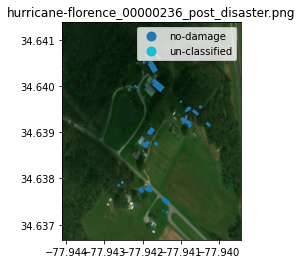

In [23]:
json_dir = "/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/xBD_data/geotiffs.old/hold/labels/"
xbd_tif_directory = "/content/drive/ai4er/python/hurricane/MyDrive/hurricane-harm-herald/data/xBD_data/geotiffs.old/hold/images"
specific_label_file = florence_json[33]
json_label = json_dir + "/" + specific_label_file

onthouden = plot_image_label(json_label, xbd_tif_directory, classes_dict)

# Plotting many many images from all hurricanes

In [24]:
def subplot_image_label(json_label, tif_dir, ax):
  # get information on damage and polygons in pandas dataframe
  polygon_damage, image_name = extract_metadata(json_label, 'polygon', classes_dict)

  # plot imagery file
  building_image_path = json_label.replace('labels', 'images').replace('json','tif')
  img = rio.open(building_image_path)
  img_extent=[img.bounds[0], img.bounds[2], img.bounds[1], img.bounds[3]]
  ax = rio.plot.show(img.read(), ax=ax, extent=img_extent)
  ax.ticklabel_format(useOffset=False)
  # overlay polygons
  polygon_damage['geometry'] = gpd.GeoSeries.from_wkt(polygon_damage['geometry'])
  my_geo_df = gpd.GeoDataFrame(polygon_damage, geometry='geometry')
  my_geo_df.plot(ax=ax, column = "damage class", legend = True, categorical=True)

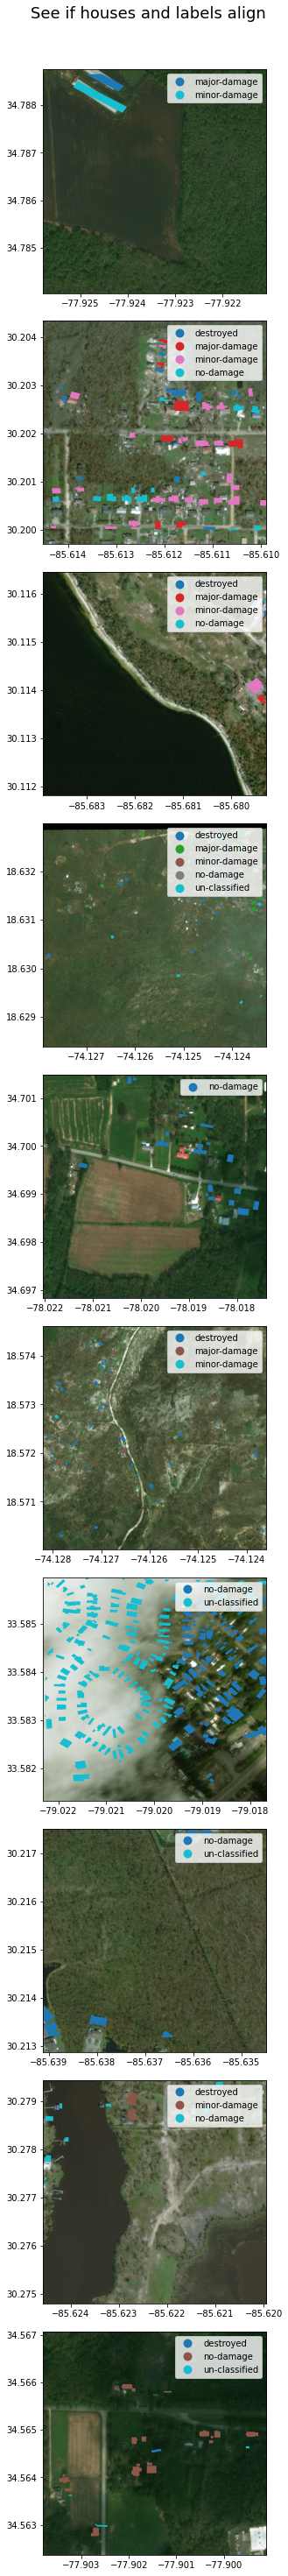

In [25]:
len(hurr_json)
json_xbd_dir = "/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/xBD_data/geotiffs.old/hold/labels/"

sliced_list = hurr_json[:20]
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(50, 40))
fig.tight_layout()
#plt.subplots_adjust(hspace=0.5)
fig.suptitle("See if houses and labels align", fontsize=18, y=1.02)

# loop through axes
for labels, ax in zip(sliced_list, axs.ravel()):
  subplot_image_label(json_xbd_dir+labels, xbd_tif_directory, ax)

# Make the EF dataset

Problem: locations in JSON file are gridded on image grid. So how to convert to normal coordinates?

In [122]:
def extract_metadata(json_link, classes_dict, type):
  json_file = open(json_link)
  json_data = json.load(json_file)
  meta_data = json_data['metadata']
  disaster_type = meta_data['disaster']
  capture_date = meta_data['capture_date']

  coordinates = json_data['features']['lng_lat']

  damage_location = []
  if type == 'point':
      def extract_location(building):
        building_polygon = building['wkt']
        building_coordinates = wkt.loads(building_polygon).centroid.wkt
        return building_coordinates
  if type == 'polygon':
    def extract_location(building):
        building_polygon = building['wkt']
        return building_polygon

  for building in coordinates:
    building_loc = extract_location(building)
    damage_class = building['properties']['subtype']
    damage_num = classes_dict[damage_class]
    
    damage_location.append([building_loc, damage_num, disaster_type, capture_date])
  df = GeoDataFrame(damage_location, columns = ['geometry', 'damage_class', 'disaster_name', 'capture_date'])
  if type == 'point':
    df["geometry"] = df['geometry'].apply(wkt.loads)
  return df

In [79]:
json_link = "/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/xBD_data/geotiffs.old/hold/labels/" + florence_json[1]
#json_link = "/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/xBD_data/geotiffs.old/hold/labels/hurricane-florence_00000006_post_disaster.json"
hallo = extract_metadata(json_link, classes_dict, 'point')

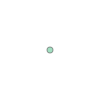

In [80]:
hallo['geometry'][0]

In [81]:
def extract_damage_allfiles(full_post_hurr_json_files, type):
  dataframes_list = []
  for file in full_post_hurr_json_files:
    loc_and_damage_df = extract_metadata(file, classes_dict, type)
    dataframes_list.append(loc_and_damage_df)  
  rdf = gpd.GeoDataFrame(pd.concat(dataframes_list, ignore_index=True))
  return rdf

In [82]:
xbd_json_directory = "/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/xBD_data/geotiffs.old/hold/labels"

In [83]:
full_post_hurr_json_files = [xbd_json_directory + "/" + i for i in posthurr_json_files]

df_points_post_hurr = extract_damage_allfiles(full_post_hurr_json_files, 'point')

In [84]:
df_points_post_hurr['capture_date'] = pd.to_datetime(df_points_post_hurr['capture_date'])

In [85]:
df_points_post_hurr['damage_class'].value_counts()

0    10531
1     6192
2     4133
3     1251
4      947
Name: damage_class, dtype: int64

In [34]:
df_points_post_hurr

,geometry,damage_class,disaster_name,capture_date
0,POINT (-77.92443 34.78850),2,hurricane-florence,2018-09-20 16:04:41+00:00
1,POINT (-77.92459 34.78817),1,hurricane-florence,2018-09-20 16:04:41+00:00
2,POINT (-85.61007 30.20004),0,hurricane-michael,2018-10-13 16:48:15+00:00
3,POINT (-85.61057 30.20001),0,hurricane-michael,2018-10-13 16:48:15+00:00
4,POINT (-85.61055 30.20060),1,hurricane-michael,2018-10-13 16:48:15+00:00
...,...,...,...,...
23049,POINT (-77.91797 34.64623),0,hurricane-florence,2018-09-20 16:04:41+00:00
23050,POINT (-77.91773 34.64628),0,hurricane-florence,2018-09-20 16:04:41+00:00
23051,POINT (-77.91765 34.64650),0,hurricane-florence,2018-09-20 16:04:41+00:00
23052,POINT (-77.91835 34.64612),0,hurricane-florence,2018-09-20 16:04:41+00:00


# Data exploration

In [36]:
df = df_points_post_hurr

In [37]:
df.describe()

/usr/local/lib/python3.8/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
<ipython-input-37-ea8415b8a3ee>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,geometry,damage_class,disaster_name,capture_date
count,23054,23054.0,23054,23054
unique,23054,5.0,4,10
top,POINT (-77.9244320492178 34.78850199541164),0.0,hurricane-harvey,2017-08-31 17:38:50.685000+00:00
freq,1,10531.0,7226,7187
first,NaN,NaN,NaN,2016-10-01 15:29:45+00:00
last,NaN,NaN,NaN,2018-10-13 16:48:15+00:00


In [38]:
num_disasters = df['disaster_name'].unique()

In [39]:
# use geopandas dataset for world map
countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))

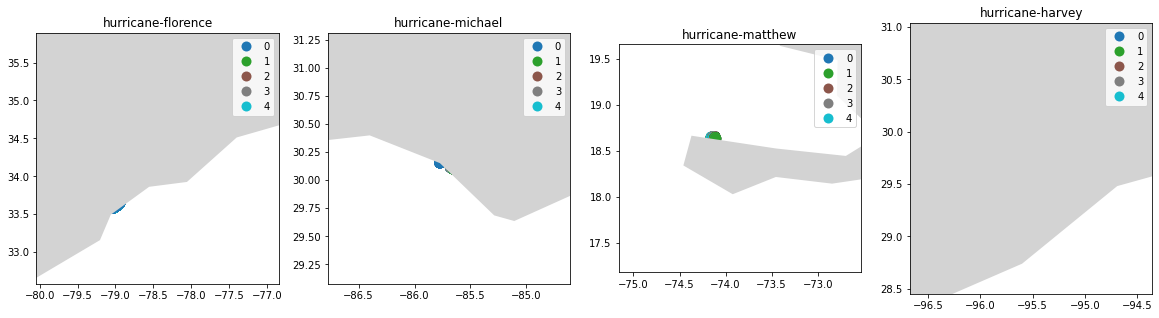

In [40]:
figs, axs = plt.subplots(1, len(num_disasters), figsize = (20,10))

for name, ax in zip(num_disasters, axs.ravel()):
  filtered_df = df[df['disaster_name'] == name]
  filtered_df.plot(ax=ax, column = "damage_class", legend = True, s=100)
  ax.set_title(name)
 # ax.get_legend().remove()
  minx, miny, maxx, maxy = filtered_df.total_bounds
  countries.plot(color="lightgrey", ax=ax)
  ax.set_xlim(minx-1, maxx+1)
  ax.set_ylim(miny-1, maxy+1)
  ax.set_xlabel("")


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f93d7886760>,
      dtype=object)

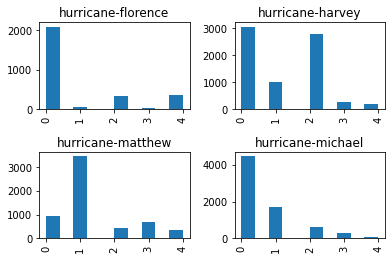

In [69]:
df_points_post_hurr['damage_class'].hist(by=df['disaster_name'])

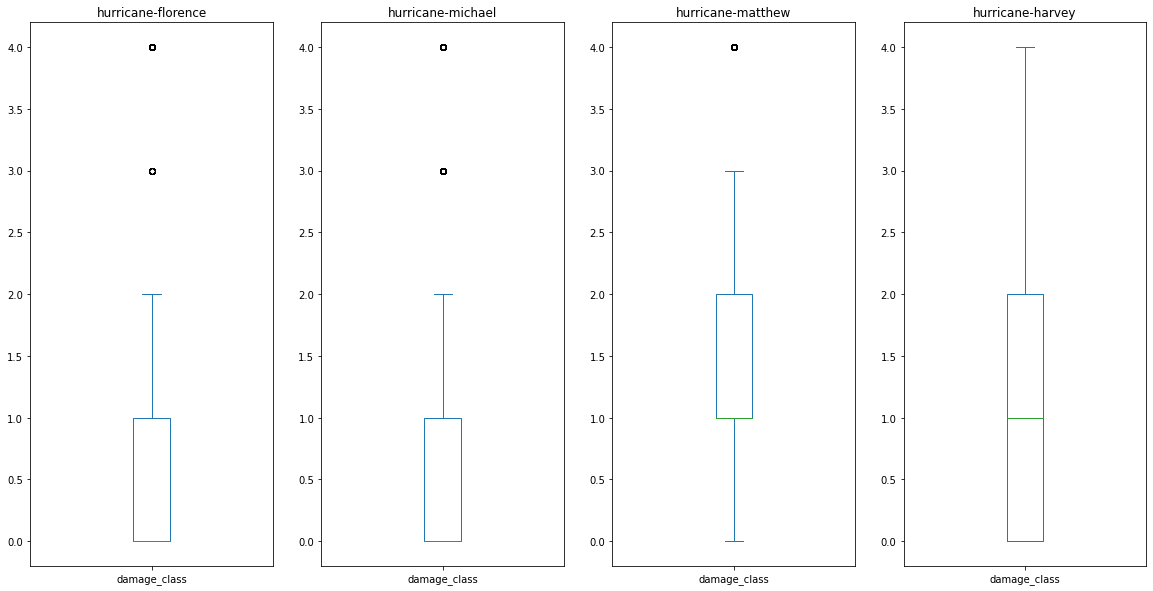

In [41]:
figs, axs = plt.subplots(1, len(num_disasters), figsize = (20,10))

for name, ax in zip(num_disasters, axs.ravel()):
  filtered_df = df[df['disaster_name'] == name]
  filtered_df["damage_class"].plot(kind='box', ax=ax)
  ax.set_title(name)

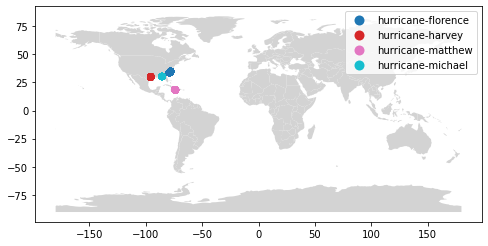

In [42]:
fig, ax = plt.subplots(figsize=(8,6))

countries.plot(color="lightgrey", ax=ax)
df_points_post_hurr.plot(column = 'disaster_name',  ax=ax, legend = True)

(13.184576127444739, 39.89044980892358)

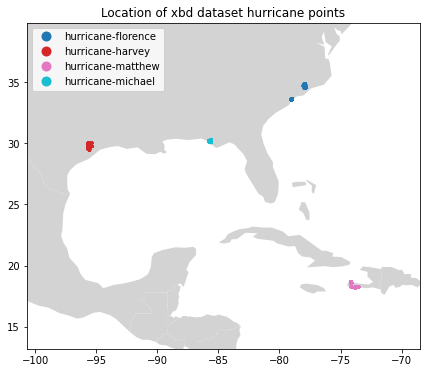

In [43]:
minx, miny, maxx, maxy = df_points_post_hurr.total_bounds

fig, ax = plt.subplots(figsize=(8,6))

countries.plot(color="lightgrey", ax=ax)
df_points_post_hurr.plot(column = 'disaster_name',  ax=ax, legend = True, s = 5)
ax.set_title("Location of xbd dataset hurricane points") # for only part a
ax.set_xlim(minx-5, maxx+5)
ax.set_ylim(miny-5, maxy+5)

Question: what do we do with unclassified?

# Evaluate polygons

In [123]:
full_post_hurr_json_files = [xbd_json_directory + "/" + i for i in posthurr_json_files]
df_pols_post_hurr = extract_damage_allfiles(full_post_hurr_json_files, 'polygon')

In [124]:
df_pols_post_hurr['capture_date'] = pd.to_datetime(df_pols_post_hurr['capture_date'])

In [125]:
df_pols_post_hurr

,geometry,damage_class,disaster_name,capture_date
0,POLYGON ((-77.92455319959544 34.78866038428011...,2,hurricane-florence,2018-09-20 16:04:41+00:00
1,POLYGON ((-77.92514765554496 34.78837713563367...,1,hurricane-florence,2018-09-20 16:04:41+00:00
2,POLYGON ((-85.61013530505083 30.19999089172758...,0,hurricane-michael,2018-10-13 16:48:15+00:00
3,POLYGON ((-85.61067567851816 30.19999661245987...,0,hurricane-michael,2018-10-13 16:48:15+00:00
4,"POLYGON ((-85.61068004041846 30.2006276951895,...",1,hurricane-michael,2018-10-13 16:48:15+00:00
...,...,...,...,...
23049,POLYGON ((-77.91800031788837 34.64610353822515...,0,hurricane-florence,2018-09-20 16:04:41+00:00
23050,POLYGON ((-77.91776776363454 34.64629766255943...,0,hurricane-florence,2018-09-20 16:04:41+00:00
23051,POLYGON ((-77.91769688532668 34.64651626627288...,0,hurricane-florence,2018-09-20 16:04:41+00:00
23052,POLYGON ((-77.91839371970048 34.64609412244859...,0,hurricane-florence,2018-09-20 16:04:41+00:00


In [128]:
df_pols_coords = df_pols_post_hurr
df_pols_coords["geometry"] = df_pols_coords['geometry'].apply(wkt.loads)

(13.184532400896138, 39.89052177529923)

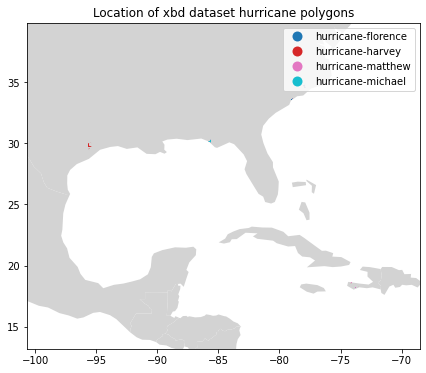

In [129]:
minx, miny, maxx, maxy = df_pols_post_hurr.total_bounds

fig, ax = plt.subplots(figsize=(8,6))

countries.plot(color="lightgrey", ax=ax)
df_pols_coords.plot(column = 'disaster_name',  ax=ax, legend = True)
ax.set_title("Location of xbd dataset hurricane polygons") # for only part a
ax.set_xlim(minx-5, maxx+5)
ax.set_ylim(miny-5, maxy+5)

Not finised
# Get histogram of sizes
Problem: can only get crs if polygon is in string shape but I cannot plot it if it is. so balancing between string and shape

In [130]:
# set and change crs
df_pols_string = df_pols_post_hurr
df_pols_string['geometry'] = df_pols_string['geometry'].apply(wkt.loads)

TypeError: ignored

In [116]:
# set in units of crs
df_pols_post_hurr['poly_area'] = df_pols_post_hurr['geometry'].area

In [117]:
df_pols_post_hurr['poly_area']

0        1.029409e-07
1        1.829440e-07
2        1.237640e-08
3        6.736832e-09
4        3.517437e-08
             ...     
23049    5.150586e-08
23050    3.065534e-09
23051    4.286989e-09
23052    5.338820e-09
23053    6.900559e-09
Name: poly_area, Length: 23054, dtype: float64

In [120]:
print(df_pols_post_hurr.crs)

None


In [118]:
df_m_pols_post_hurr = df_pols_post_hurr.to_crs(epsg=6933)

ValueError: ignored

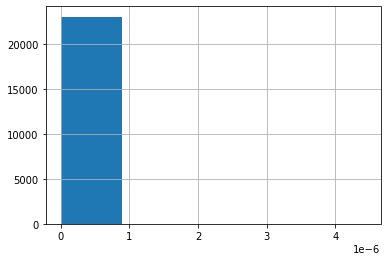

In [97]:
df_pols_post_hurr['poly_area'].hist(bins=5)

In [92]:
df_pols_post_hurr['poly_area'].hist(by=df['disaster_name'], bins = 5)

KeyError: ignored

## Save new file

In [ ]:
!pwd

In [ ]:
%cd /content/drive/MyDrive/hurricane-harm-herald/data/xBD_data/geotiffs.old/

In [ ]:
df_points_post_hurr.to_pickle("./df_points_posthurr.pkl")